c:\Users\mesne\anaconda3\envs\python_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


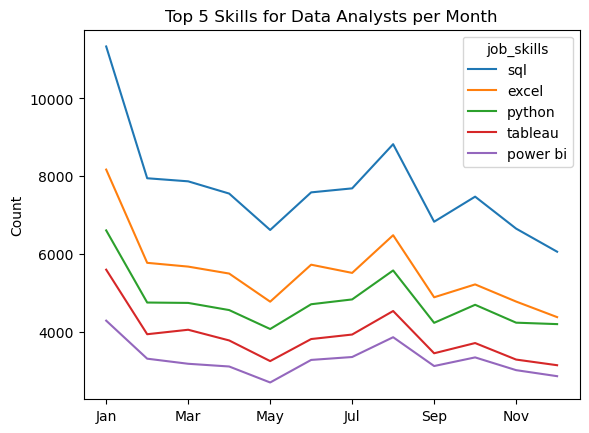

In [ ]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy() #Filtered

# create a new column for month number
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

# Explode the job_skills column and pivot
df_DA_explode= df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills',  aggfunc='size', fill_value=0)

# sort the skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# Use month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# Get the top 5 skills
df_DA_pivot.iloc[:, :5].plot(kind='line')

plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

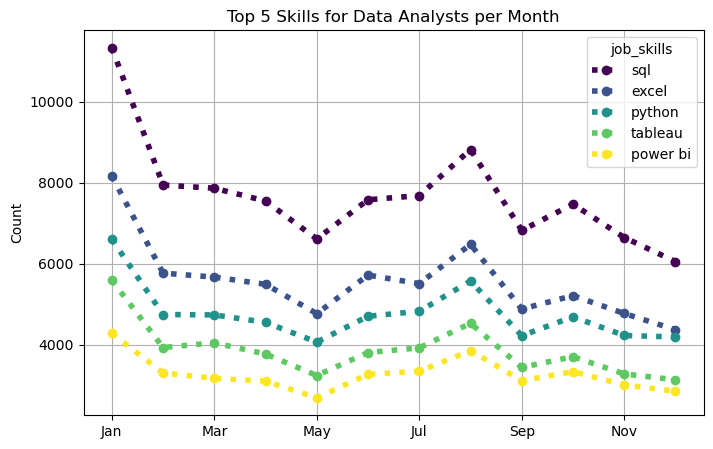

In [29]:
df_DA_pivot.iloc[:,:5].plot(
    kind='line',
    linewidth=4,
    linestyle=':', #options: '-','--','-.',':'
    colormap='viridis',#options:'viridis'.'plasma','inferno','magma','cividis'
    marker='o',#options: 'x','*','+','1','2'...
    markersize=6,
    figsize=(8,5) #Width,height of plot
    
    
)
plt.grid(True)
plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [30]:
# Explode the 'job_skills' into individual rows
df_exploded = df_DA.explode('job_skills')

# Calculate the average salary and count of job postings per skill
skill_stats = df_exploded.groupby('job_skills').agg(
    median_salary=('salary_year_avg', 'median'),
    skill_count=('job_skills', 'count')
)

# Limit to the top skills
skill_count = 20
skill_stats = skill_stats.sort_values(by='skill_count', ascending=False).head(skill_count)
skill_stats

,median_salary,skill_count
job_skills,,
sql,92500.000000,92428
excel,84479.000000,66860
python,98500.000000,57190
tableau,95000.000000,46455
power bi,90000.000000,39380
r,92527.500000,29996
sas,90000.000000,27998
powerpoint,85000.000000,13822
word,80000.000000,13562


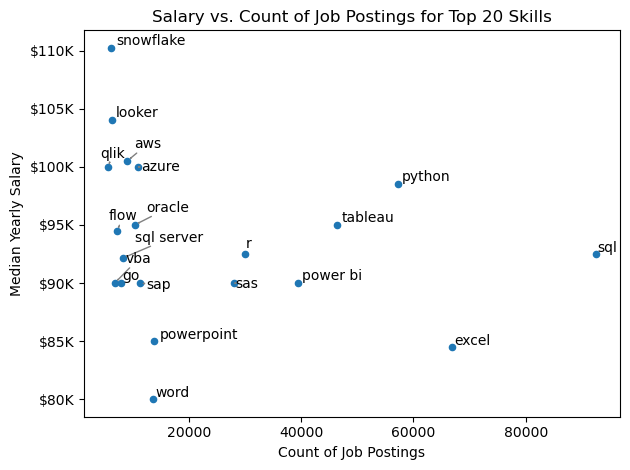

In [ ]:
from adjustText import adjust_text

skill_stats.plot(kind='scatter', x='skill_count', y='median_salary')

texts=[]
for i, txt in enumerate(skill_stats.index):
    texts.append(plt.text(skill_stats['skill_count'].iloc[i], skill_stats['median_salary'].iloc[i], txt))
    
adjust_text(texts,arrowprops=dict(arrowstyle="->",color='gray',lw=1))

ax=plt.gca()  #Must be after plot generation,gca-get current axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,pos : f'${int(y/1000)}K' ))
#pos refers to the tick positions

plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary')
plt.title(f'Salary vs. Count of Job Postings for Top {skill_count} Skills')
plt.tight_layout()
plt.show()